In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats2020-training-data/BraTS20 Training Metadata.csv


In [3]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 2


In [4]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is being used!")
    except RuntimeError as e:
        print(e)

GPU is being used!


In [5]:
!nvidia-smi

Fri Mar 21 09:13:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats2020-training-data")

# Define dataset path dynamically
DATASET_PATH = os.path.join(path, "BraTS2020_training_data/content/data")

# Check if dataset path exists before listing contents
if os.path.exists(DATASET_PATH):
    print("Dataset Path Exists")
    print(os.listdir(DATASET_PATH)[:10])
else:
    print("Error: Dataset path does not exist")



Dataset Path Exists
['volume_337_slice_56.h5', 'volume_293_slice_67.h5', 'volume_149_slice_44.h5', 'volume_109_slice_17.h5', 'volume_201_slice_137.h5', 'volume_27_slice_115.h5', 'volume_128_slice_38.h5', 'volume_268_slice_18.h5', 'volume_114_slice_125.h5', 'volume_65_slice_18.h5']


In [7]:
import os

file_path = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_100_slice_0.h5"
print("File exists:", os.path.exists(file_path))

with open(file_path, 'rb') as f:
    signature = f.read(8)
    print("File signature:", signature)

File exists: True
File signature: b'\x89HDF\r\n\x1a\n'


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_sample(file_path):
    with h5py.File(file_path, 'r') as f:
        image = np.array(f['image'])
        mask = np.array(f['mask'])

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title("MRI Scan")

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Segmentation Mask")

    plt.show()

    print("Image min, max:", image.min(), image.max())
    print("Mask unique values:", np.unique(mask))

In [9]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    file_list = sorted([f for f in os.listdir(dataset_path) if f.endswith('.h5') or f.endswith('.hdf5')])

    if not file_list:
        raise ValueError("No HDF5 files found in the dataset directory!")

    train_files, temp_files = train_test_split(file_list, test_size=(1 - train_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    return train_files, val_files, test_files

train_files, val_files, test_files = split_dataset(DATASET_PATH)

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Train: 40036, Val: 11439, Test: 5720


In [10]:
import albumentations as A
import numpy as np
import h5py
import os
import random
import cv2

# ✅ Updated Augmentation: More robust, ensures mask integrity, preserves 4-channel input
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.OneOf([
        A.ElasticTransform(alpha=1, sigma=50, p=0.5),
        A.GridDistortion(p=0.5)
    ], p=0.5)
], additional_targets={'mask': 'mask'})

def preprocess_image(img):
    if len(img.shape) == 2:  
        img = np.stack([img] * 4, axis=-1)  # Convert grayscale to 4-channel
    elif img.shape[-1] == 3:  
        img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)  # Convert RGB → RGBA

    img = cv2.resize(img, (128, 128))
    
    img = img.astype(np.float32)  # Ensure float32
    img -= img.min()  # Normalize to range [0,1]
    img /= img.max() + 1e-8  # Avoid division by zero
    
    return img
  # No need to expand dims, already (128,128,4)

def preprocess_mask(mask):
    """ Convert masks to single-channel, resize, and binarize. """
    if len(mask.shape) == 3 and mask.shape[-1] == 3:  
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)  

    mask = cv2.resize(mask, (128, 128))  
    mask = (mask > 0).astype(np.uint8)  # Binary mask
    return np.expand_dims(mask, axis=-1)  

def load_hdf5_images(dataset_path, file_list, batch_size=8, augment=False):
    """
    Infinite generator function for training, shuffling data each epoch.
    """
    while True:  
        random.shuffle(file_list)  

        for i in range(0, len(file_list), batch_size):
            batch_files = file_list[i : i + batch_size]

            images, masks = [], []
            
            for filename in batch_files:
                file_path = os.path.join(dataset_path, filename)

                try:
                    with h5py.File(file_path, 'r') as f:
                        if 'image' not in f or 'mask' not in f:
                            continue  

                        img = np.array(f['image'][:], dtype=np.float32)
                        mask = np.array(f['mask'][:], dtype=np.uint8)

                        img = preprocess_image(img)
                        mask = preprocess_mask(mask)

                        if augment:
                            augmented = augmentation(image=img, mask=mask.squeeze())
                            img = augmented['image']
                            mask = np.expand_dims(augmented['mask'], axis=-1)

                        # Ensure image remains 4-channel after augmentation
                        if img.shape[-1] != 4:
                            img = np.stack([img[..., 0]] * 4, axis=-1)

                        images.append(img)
                        masks.append(mask)

                except Exception as e:  
                    print(f"Skipping file {filename}: {e}")
            
            if images:  
                yield np.array(images), np.array(masks)

# ✅ Corrected Generator Creation
train_gen = load_hdf5_images(DATASET_PATH, train_files, batch_size=8, augment=True)
val_gen = load_hdf5_images(DATASET_PATH, val_files, batch_size=8, augment=False)
test_gen = load_hdf5_images(DATASET_PATH, test_files, batch_size=8, augment=False)

# ✅ Load one batch for testing
X_batch, y_batch = next(train_gen)
print("Fixed batch shape:", X_batch.shape, y_batch.shape)

/usr/local/lib/python3.10/dist-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


Fixed batch shape: (8, 128, 128, 4) (8, 128, 128, 1)


[0 1]


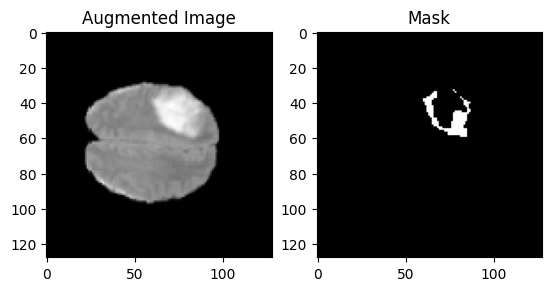

float32 uint8
0.0 1.0
0 1


In [11]:
print(np.unique(y_batch))  # Should output: [0 1]

import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(X_batch[0][..., 0], cmap="gray")  # First channel of image
plt.title("Augmented Image")

plt.subplot(1, 2, 2)
plt.imshow(y_batch[0].squeeze(), cmap="gray")
plt.title("Mask")
plt.show()

print(X_batch.dtype, y_batch.dtype)  # Should be float32, uint8
print(X_batch.min(), X_batch.max())  # Should be ~0 to 1
print(y_batch.min(), y_batch.max())  # Should be 0 or 1

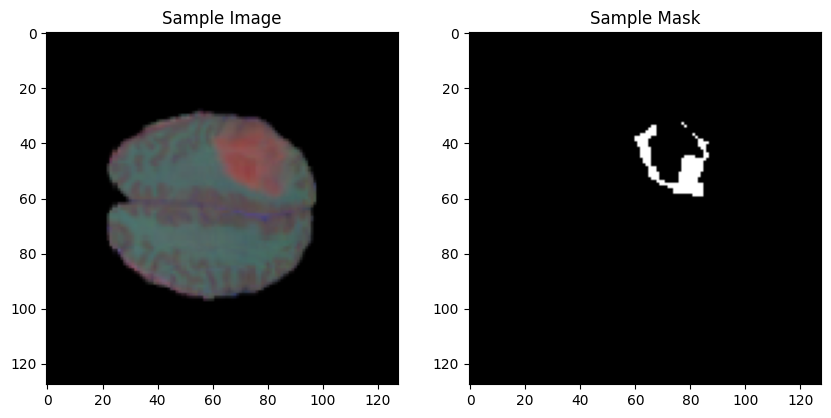

In [12]:
import matplotlib.pyplot as plt

# Get a sample from the batch
sample_img = X_batch[0]  # Shape: (128, 128, 4)
sample_mask = y_batch[0].squeeze()  # Shape: (128, 128)

# Convert image to RGB for visualization (taking first 3 channels)
sample_img_rgb = sample_img[..., :3]  

# Plot image and mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sample_img_rgb)  # Show RGB version
axes[0].set_title("Sample Image")

axes[1].imshow(sample_mask, cmap="gray")  # Show mask in grayscale
axes[1].set_title("Sample Mask")

plt.show()

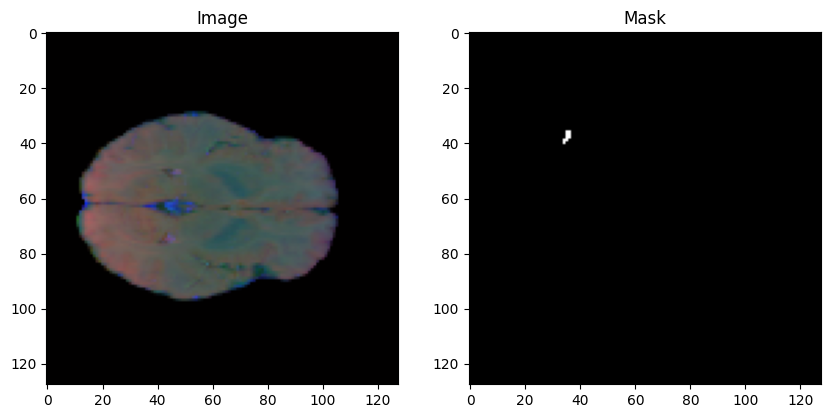

In [13]:
import matplotlib.pyplot as plt

# Get a sample batch
X_batch, y_batch = next(train_gen)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display Image (First 3 channels for RGB)
axes[0].imshow(X_batch[0, :, :, :3])  # Show RGB image
axes[0].set_title("Image")

# Display Mask
axes[1].imshow(y_batch[0, :, :, 0], cmap='gray')  # Single-channel mask
axes[1].set_title("Mask")

plt.show()

In [14]:
import tensorflow.keras.backend as K

# IoU Metric
def iou_metric(y_true, y_pred, threshold=0.5):
    y_true = K.cast(y_true, dtype='float32')  # Ensure same dtype
    y_pred = K.cast(y_pred > threshold, dtype='float32')  # Convert to binary mask
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

# Dice Score
def dice_metric(y_true, y_pred, threshold=0.5):
    y_true = K.cast(y_true, dtype='float32')  # Ensure same dtype
    y_pred = K.cast(y_pred > threshold, dtype='float32')  # Convert to binary mask
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model

def segnet_model(input_size=(128, 128, 4)):
    inputs = Input(shape=input_size)

    # Encoder
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Decoder
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Compile the Model
model = segnet_model()
optimizer = Adam(learning_rate=1e-4)  # Reduce learning rate for stable training
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', dice_metric, iou_metric])

# Print Model Summary
model.summary()

# Set batch size and calculate steps per epoch
BATCH_SIZE = 8
train_steps_per_epoch = len(train_files) // BATCH_SIZE if isinstance(train_files, list) else None
val_steps_per_epoch = len(val_files) // BATCH_SIZE if isinstance(val_files, list) else None

print(f"Steps per epoch (Train): {train_steps_per_epoch}")
print(f"Steps per epoch (Validation): {val_steps_per_epoch}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 256)         │           1,0

 Total params: 5,467,841 (20.86 MB)

 Trainable params: 5,464,001 (20.84 MB)

 Non-trainable params: 3,840 (15.00 KB)

Steps per epoch (Train): 5004
Steps per epoch (Validation): 1429


In [17]:
print(f"Train Steps per Epoch: {train_steps_per_epoch}")
print(f"Validation Steps per Epoch: {val_steps_per_epoch}")

Train Steps per Epoch: 5004
Validation Steps per Epoch: 1429


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=16,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    callbacks=[
        ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min"),  # ✅ Change to `.keras`
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
    ]
)

Epoch 1/16
5004/5004 ━━━━━━━━━━━━━━━━━━━━ 968s 190ms/step - accuracy: 0.9539 - dice_metric: 0.4175 - iou_metric: 0.2934 - loss: 0.2855 - val_accuracy: 0.9958 - val_dice_metric: 0.6358 - val_iou_metric: 0.4892 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 2/16
5004/5004 ━━━━━━━━━━━━━━━━━━━━ 831s 166ms/step - accuracy: 0.9961 - dice_metric: 0.6203 - iou_metric: 0.4719 - loss: 0.0110 - val_accuracy: 0.9957 - val_dice_metric: 0.4318 - val_iou_metric: 0.3057 - val_loss: 0.0123 - learning_rate: 1.0000e-04
Epoch 3/16
5004/5004 ━━━━━━━━━━━━━━━━━━━━ 855s 171ms/step - accuracy: 0.9967 - dice_metric: 0.6715 - iou_metric: 0.5268 - loss: 0.0082 - val_accuracy: 0.9971 - val_dice_metric: 0.7107 - val_iou_metric: 0.5731 - val_loss: 0.0073 - learning_rate: 1.0000e-04
Epoch 4/16
5004/5004 ━━━━━━━━━━━━━━━━━━━━ 830s 166ms/step - accuracy: 0.9971 - dice_metric: 0.7100 - iou_metric: 0.5715 - loss: 0.0071 - val_accuracy: 0.9973 - val_dice_metric: 0.7221 - val_iou_metric: 0.5864 - val_loss: 0.0067 - le

In [19]:
model.save("brats_segnet_model.keras")

In [20]:
from IPython.display import FileLink

# Provide download link
FileLink('best_model.keras')

/kaggle/working/best_model.keras

In [21]:
#Save history as CSV

import pandas as pd

# Convert history.history to DataFrame
history_df = pd.DataFrame(history.history)

# Save to CSV
history_df.to_csv('training_history.csv', index=False)

In [22]:
# If you're using Kaggle, this will create a download link:
from IPython.display import FileLink
FileLink("training_history.csv")

/kaggle/working/training_history.csv

In [23]:
#Save history as pickle

import pickle

# Save
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [24]:
# Download link (Kaggle notebook)
FileLink("training_history.pkl")

/kaggle/working/training_history.pkl

In [ ]:
# Load Pickle
with open("training_history.pkl", "rb") as f:
    loaded_history = pickle.load(f)

# Now use loaded_history like before

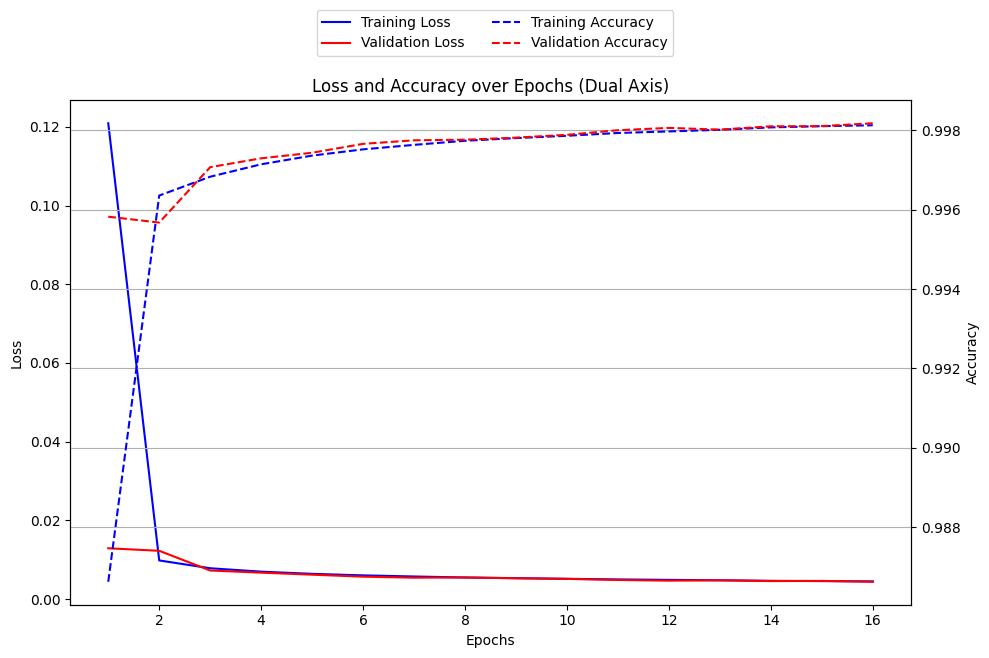

In [25]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Loss (Left Y-axis)
ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Twin axis for Accuracy (Right Y-axis)
ax2 = ax1.twinx()
ax2.plot(epochs, train_acc, 'b--', label='Training Accuracy')
ax2.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
ax2.set_ylabel('Accuracy', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Legends
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.title('Loss and Accuracy over Epochs (Dual Axis)')
plt.grid(True)
plt.tight_layout()
plt.show()


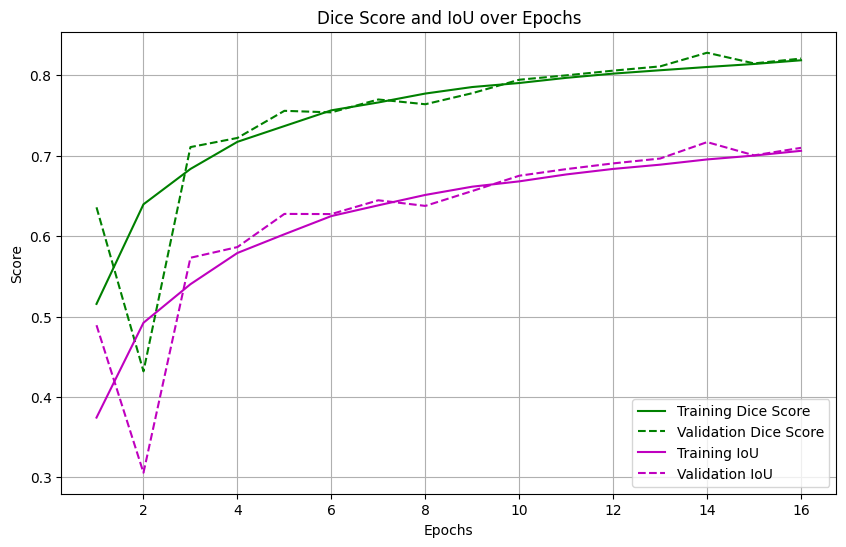

In [26]:
#Dice vs IoU
train_dice = history.history['dice_metric']
val_dice = history.history['val_dice_metric']
train_iou = history.history['iou_metric']
val_iou = history.history['val_iou_metric']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_dice, 'g-', label='Training Dice Score')
plt.plot(epochs, val_dice, 'g--', label='Validation Dice Score')
plt.plot(epochs, train_iou, 'm-', label='Training IoU')
plt.plot(epochs, val_iou, 'm--', label='Validation IoU')
plt.title('Dice Score and IoU over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


Collected predictions: 655360


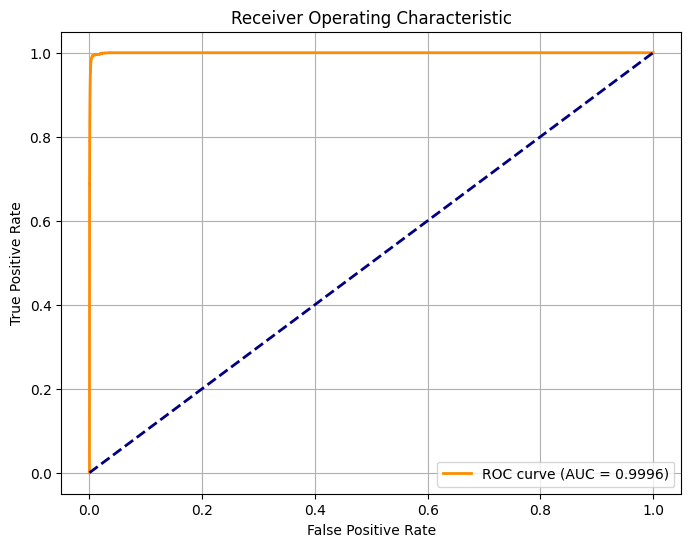

In [27]:
# RECREATE the generator here
# Re-initialize the validation generator
val_gen = load_hdf5_images(DATASET_PATH, val_files, batch_size=8, augment=False)


val_gen_iter = iter(val_gen)

y_true = []
y_prob = []
desired_steps = 5  # Reduce if needed

for i in range(desired_steps):
    try:
        x, y = next(val_gen_iter)
        preds = model.predict(x, verbose=0)

        y_true.extend(y.flatten())
        y_prob.extend(preds.flatten())
    except StopIteration:
        print(f"Stopped early at step {i+1}. Generator exhausted.")
        break

import numpy as np
y_true = np.array(y_true)
y_prob = np.array(y_prob)

print("Collected predictions:", len(y_true))

if y_true.size == 0:
    print("No data collected. Try smaller steps or fix generator.")
else:
    y_true = np.round(y_true)
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


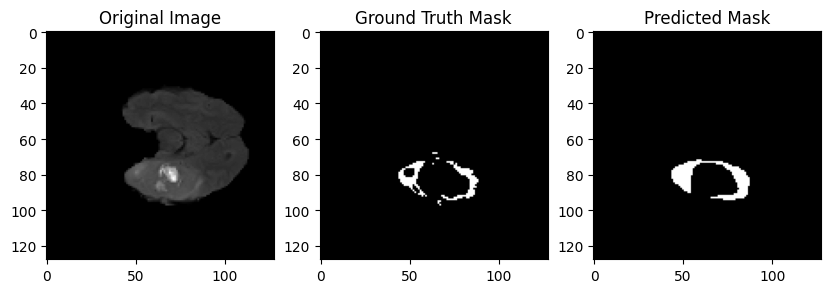

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Load one batch from test generator
X_test, y_test = next(test_gen)

# Predict
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("uint8")  # Threshold to binary mask

# Plot the first sample
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(X_test[0, :, :, 0], cmap="gray")  # Select first channel

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(y_test[0].squeeze(), cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(y_pred[0].squeeze(), cmap="gray")

plt.show()

In [26]:
from tensorflow.keras.metrics import MeanIoU

mean_iou = MeanIoU(num_classes=2)  # Binary segmentation (0 or 1)